In [31]:
import sys
import os
import torchvision
from typing import List
import pandas as pd
from datetime import datetime
import torch.utils.data as dt
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import OrderedDict

# Add the deepfakedetection directory to the path if needed
sys.path.append('/home/vishnu/AAT/Self/deepfakedetection')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Fix the paths to point to the deepfakedetection directory
DIR_DATA_INFO = '/home/vishnu/AAT/Self/deepfakedetection/140k-real-and-fake-faces/'

DIR_DATA = '/home/vishnu/AAT/Self/deepfakedetection/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/'
DIR_DATA_TPDNE = '/home/vishnu/AAT/Self/deepfakedetection/tpdne-60k-128x128/'
DIR_DATA_CELEBA = '/home/vishnu/AAT/Self/deepfakedetection/celeba-dataset/img_align_celeba/img_align_celeba/'

URL_DATA = 'https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces'
URL_DATA_TPDNE = 'https://www.kaggle.com/datasets/potatohd404/tpdne-60k-128x128'
URL_DATA_CELEBA = 'https://www.kaggle.com/jessicali9530/celeba-dataset'

LABEL_FAKE = 0
LABEL_REAL = 1

IMAGE_SIZE = 64
TEST_SIZE = 1000

DATA_TYPES = ['train', 'test', 'valid']

def get_data_info_file(data_type: str, data_info_dir: List[str]=DIR_DATA_INFO) -> str:
    assert data_type in DATA_TYPES
    return os.path.join(data_info_dir, f'{data_type}.csv')

In [4]:
class Flatten(nn.Module):
    def forward(self, x):
        N = x.shape[0]
        return x.view(N, -1)

In [5]:
def cnn_model() -> nn.Module:
    return nn.Sequential(
           nn.Conv2d(3, 32, kernel_size=7, padding=3),
           nn.ReLU(),
           nn.Dropout2d(p=0.2),
           nn.Conv2d(32, 64, kernel_size=3, padding=1),
           nn.ReLU(),
           nn.Dropout2d(p=0.2),
           nn.MaxPool2d(kernel_size=4, stride=4),
           nn.Conv2d(64, 64, kernel_size=3, padding=1),
           nn.ReLU(),
           nn.Dropout2d(p=0.2),
           nn.Conv2d(64, 128, kernel_size=3, padding=1),
           nn.ReLU(),
           nn.Dropout2d(p=0.2),
           nn.MaxPool2d(kernel_size=4, stride=4),
           Flatten(),
           nn.Linear(128 * (IMAGE_SIZE // 16) ** 2, 1),
           nn.Sigmoid(),
        )

In [6]:
def load_data_info(data_type, source='local'):
  if source == 'local':
    data_info = pd.read_csv(get_data_info_file(data_type))
    data_info['image'] = data_info['path'].apply(lambda path: os.path.join(DIR_DATA, path))
    data_info['label'] = data_info['label'].astype(int)
    if data_type == 'test':
      data_info = data_info.sample(TEST_SIZE)
    return data_info[['image', 'label']]
  
  if source == 'tpdne':
    data_info = pd.DataFrame(columns=['image', 'label'])
    data_info['image'] = pd.Series([f"{DIR_DATA_TPDNE}/{f_img}" for f_img in os.listdir(DIR_DATA_TPDNE)[:TEST_SIZE]])
    data_info['label'] = LABEL_FAKE
    return data_info
  
  if source == 'celeba':
    data_info = pd.DataFrame(columns=['image', 'label'])
    data_info['image'] = pd.Series([f"{DIR_DATA_CELEBA}/{f_img}" for f_img in os.listdir(DIR_DATA_CELEBA)[:TEST_SIZE]])
    data_info['label'] = LABEL_REAL
    return data_info

In [7]:
class FaceImageDataset(torch.utils.data.Dataset):

    def __init__(
            self,
            data_type: str,
            mean: torch.Tensor=0,
            std: torch.Tensor=1,
            do_augment: bool=False,
            do_fft: bool=False,
            source: str='local'):
        self.data_type = data_type
        self.mean = mean
        self.std = std
        self.do_augment = do_augment
        self.do_fft = do_fft
        self.source = source

        image_info = load_data_info(data_type, source)
        self.image_files = image_info['image'].values
        self.image_labels = image_info['label'].values

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx])

        augment = torchvision.transforms.Compose([
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomRotation(180),
            torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            torchvision.transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
        ])
        fft = lambda x: torch.fft.fft2(x).abs()
        tensorize = torchvision.transforms.Compose([
            torchvision.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            torchvision.transforms.ToTensor(),
        ])
        normalize = torchvision.transforms.Normalize(mean=self.mean, std=self.std)

        if self.do_augment:
            image = augment(image)

        image = tensorize(image)
                
        if self.do_fft:
            image = fft(image)

        image = normalize(image)

        image = image.to(device)
        label = torch.tensor(self.image_labels[idx], dtype=torch.float).expand(1).to(device)
            
        return (image, label)

In [10]:
# def compute_mean_and_std(dataset):
#     loader = dt.DataLoader(dataset, batch_size=64, shuffle=False)
#     mean = torch.zeros(3)
#     std = torch.zeros(3)
#     num_samples = 0.0

#     for (image, _) in tqdm(loader):
#         batch_samples = image.size(0)
#         color_channels = image.size(1)
#         image = image.view(batch_samples, color_channels, -1)
#         mean += image.mean(2).sum(0)
#         std += image.std(2).sum(0)
#         num_samples += batch_samples

#     mean /= num_samples
#     std /= num_samples

#     mean = mean.to(device)
#     std = std.to(device)

#     return mean, std

In [11]:
# print("Getting mean and std...")
# mean, std = compute_mean_and_std(FaceImageDataset('train'))
# mean_fft, std_fft = compute_mean_and_std(FaceImageDataset('train', do_fft=True))
# mean_aug, std_aug = compute_mean_and_std(FaceImageDataset('train', do_augment=True))

In [8]:
mean = torch.tensor([0.5209, 0.4259, 0.3807])
std = torch.tensor([0.2399, 0.2145, 0.2120])

In [9]:
model_name, f_model, do_fft, do_aug, mean, std = 'cnn-aug', cnn_model, False, True, mean, std

In [10]:
print(f"Model: {model_name}, FFT: {do_fft}, Augmentation: {do_aug}")

Model: cnn-aug, FFT: False, Augmentation: True


In [11]:
model = f_model()
model = model.to(device)
train_data = FaceImageDataset('train', mean=mean, std=std, do_fft=do_fft, do_augment=do_aug)
val_data = FaceImageDataset('valid', mean=mean, std=std, do_fft=do_fft, do_augment=do_aug)

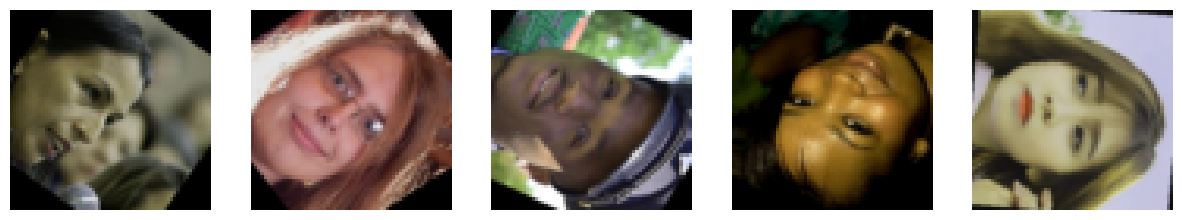

In [12]:
from PIL import Image

first_5_images = [train_data[i][0] for i in range(5)]
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for ax, img_tensor in zip(axes, first_5_images):
    img = img_tensor.permute(1, 2, 0).numpy()  # Convert tensor to numpy array and rearrange dimensions
    img = (img * std.numpy() + mean.numpy()).clip(0, 1)  # Denormalize the image
    ax.imshow(img)
    ax.axis('off')
plt.show()

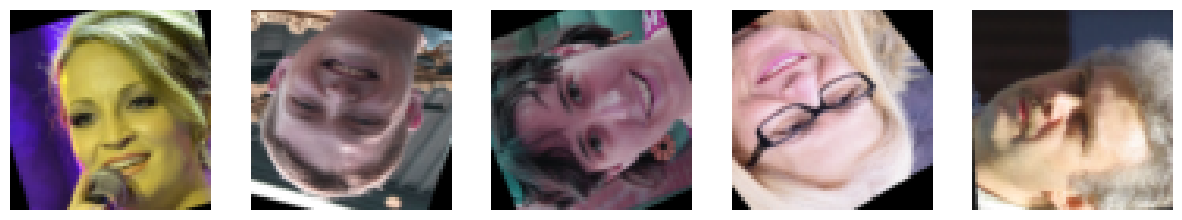

In [13]:
first_5_images = [val_data[i][0] for i in range(5)]

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for ax, img_tensor in zip(axes, first_5_images):
    img = img_tensor.permute(1, 2, 0).numpy()  # Convert tensor to numpy array and rearrange dimensions
    img = (img * std.numpy() + mean.numpy()).clip(0, 1)  # Denormalize the image
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [14]:
model

Sequential(
  (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (1): ReLU()
  (2): Dropout2d(p=0.2, inplace=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): Dropout2d(p=0.2, inplace=False)
  (6): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): Dropout2d(p=0.2, inplace=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Dropout2d(p=0.2, inplace=False)
  (13): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (14): Flatten()
  (15): Linear(in_features=2048, out_features=1, bias=True)
  (16): Sigmoid()
)

In [15]:
TRAIN_EPOCHS = 12
BATCH_SIZE = 64
SAVED_MODELS_DIR = "saved_models"
LOGS_DIR = "logs"

def get_timestamp() -> str:
   return datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

def get_saved_model_path(model_name: str, timestamp: str) -> str:
    return f"{SAVED_MODELS_DIR}/{model_name}/{timestamp}.pt"

def get_log_dir(model_name: str, timestamp: str) -> str:
    return f"{LOGS_DIR}/{model_name}/{timestamp}/"

In [ ]:
def test_model(model: nn.Module, dataset: dt.Dataset):
  model = model.to(device)  # Move model to device
  model.eval()
  dataloader = dt.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
  with torch.no_grad():
    acc = 0
    num_samples = 0
    for (x, y) in tqdm(dataloader):
      x, y = x.to(device), y.to(device)  # Move data to the same device as model
      scores = model(x)
      y_pred = scores > 0.5
      acc += torch.count_nonzero(y_pred == y)
      num_samples += len(y)
  model.train()
  return acc / num_samples

In [ ]:
def train_model(model_name: str, model: nn.Module, train_data: dt.Dataset, val_data: dt.Dataset):
  timestamp = get_timestamp()
  model_save_path = get_saved_model_path(model_name, timestamp)
  log_dir = get_log_dir(model_name, timestamp)
  os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
  
  model = model.to(device)
  
  writer = SummaryWriter(log_dir=log_dir)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
  criterion = nn.BCELoss().to(device)
  dataloader = dt.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.2)

  last_val_acc = 0
  val_acc_decreasing_counter = 0
  global_step = 0
  model.train()
  for epoch in range(TRAIN_EPOCHS):
    print(f"Epoch {epoch + 1}/{TRAIN_EPOCHS}")
    torch.save(model.state_dict(), model_save_path)   

    for data in tqdm(dataloader):
      optimizer.zero_grad()
      x, y = data
      x, y = x.to(device), y.to(device)  # Move data to the same device as model
      scores = model(x)
      y_pred = scores > 0.5
      acc = torch.count_nonzero(y_pred == y) / len(y_pred)
      loss = criterion(scores, y)
      loss.backward()
      optimizer.step()

      writer.add_scalar("loss", loss.item(), global_step=global_step)
      writer.add_scalar("acc/train", acc, global_step=global_step)

      global_step += 1

    val_acc = test_model(model, val_data)
    if val_acc < last_val_acc:
      val_acc_decreasing_counter += 1
    else:
      val_acc_decreasing_counter = 0

    writer.add_scalar("acc/val", val_acc, global_step=global_step)
    lr_scheduler.step()
    writer.flush()

    if val_acc_decreasing_counter >= 3:
      print("Stopping early due to decreasing validation accuracy")
      break

  torch.save(model.state_dict(), model_save_path)   
  writer.close() 

In [ ]:
print(f"Training {model_name}...")
train_model(model_name, model, train_data, val_data)

### Analysis

In [17]:
SAVED_MODEL_DIR = 'saved_models'

In [18]:
DATASET_SPECS = [
  # ('normal', 'train', 0, 1, False, False),
  ('aug', 'train', 0, 1, True, False),
  # ('fft', 'train', 0, 1, False, True),
]

In [19]:
SPECS = [
  # ('cnn', cnn_model, False, False, mean, std),
  ('cnn-aug', cnn_model, False, True, mean, std),
]

In [20]:
def get_most_recent_model(model):
  model_dir = f'{SAVED_MODEL_DIR}/{model}'
  if not os.path.exists(model_dir):
    return None
  files = os.listdir(model_dir)
  if not files:
    return None
  return f'{model_dir}/{sorted(files)[-1]}'

In [21]:
CNN_MODELS = [
  model for model in [
    ('cnn', get_most_recent_model('cnn')),
    # ('cnn-aug', get_most_recent_model('cnn-aug')),
    # ('cnn-fft', get_most_recent_model('cnn-fft')),
  ] if model[1] is not None
]

In [22]:
def tensor_to_image(tensor):
  image = tensor.cpu().numpy().transpose((1, 2, 0))
  image = (image * 255).astype('uint8')
  return image

In [23]:
def plot_image(img, path):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  if not os.path.exists(os.path.dirname(path)):
    os.makedirs(os.path.dirname(path))
  cv2.imwrite(path, img)

In [24]:
def squash_tensor(tensor):
  return torch.clip(tensor / 100, 0, 1)

In [ ]:
def plot_sample_images():
  fake_images = []
  real_images = []
  dataset = FaceImageDataset('train')
  while len(fake_images) < 10 or len(real_images) < 10:
    i = np.random.randint(len(dataset))
    image, label = dataset[i]
    if label == 0:
      if len(fake_images) < 10:
        fake_images.append(i)
    else:
      if len(real_images) < 10:
        real_images.append(i)
  
  for spec in DATASET_SPECS:
    name, args = spec[0], spec[1:]
    dataset = FaceImageDataset(*args)
    for idx, i in enumerate(fake_images):
      image, _ = dataset[i]
      if name == 'fft':
        image = squash_tensor(image)
      plot_image(tensor_to_image(image), f'plots/sample-images/{name}/fake/{idx}.png')

    for i in real_images:
      image, _ = dataset[i]
      if name == 'fft':
        image = squash_tensor(image)
      plot_image(tensor_to_image(image), f'plots/sample-images/{name}/real/{i}.png')

In [ ]:
def evaluate_models():
  df = pd.DataFrame(columns=['model', 'accuracy'])
  for source in ['local', 'tpdne', 'celeba']:
    for spec in SPECS:
      model_name, f_model, do_fft, _, mean, std = spec
      print(f"Evaluating model {model_name} on dataset {source}...")
      data = FaceImageDataset('test', source=source, do_fft=do_fft, do_augment=False, mean=mean, std=std)
      model = f_model()
      f_saved_model = os.listdir(f"../deepfakedetection/{SAVED_MODELS_DIR}/{model_name}")[0]

      state_dict = torch.load(f"../deepfakedetection/{SAVED_MODELS_DIR}/{model_name}/{f_saved_model}", map_location="cpu")

      # create new OrderedDict without "module."
      new_state_dict = OrderedDict()
      for k, v in state_dict.items():
          name = k.replace("module.", "")  # remove `module.`
          new_state_dict[name] = v

      model.load_state_dict(new_state_dict)
      acc = test_model(model, data)
      print(f"Accuracy: {acc.item()}")
      df = df._append({'model': model_name, 'accuracy': acc.item(), 'source': source}, ignore_index=True)

In [33]:
evaluate_models()

Evaluating model cnn-aug on dataset local...


100%|██████████| 16/16 [00:02<00:00,  5.35it/s]


Accuracy: 0.6700000166893005
Evaluating model cnn-aug on dataset tpdne...


100%|██████████| 16/16 [00:02<00:00,  6.39it/s]


Accuracy: 0.8610000014305115
Evaluating model cnn-aug on dataset celeba...


100%|██████████| 16/16 [00:02<00:00,  6.95it/s]

Accuracy: 0.8240000009536743


In [ ]:
def plot_cnn_filters():
  # model = nn.DataParallel(cnn_model())
  model = cnn_model()
  for name, path in CNN_MODELS:
    model.load_state_dict(torch.load(path))
    model.eval()
    tensor = model.module[0].weight.data.clone().cpu()  # Move to CPU
    nrow = 8
    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=1)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.title(f"{name} Shallow CNN 7x7 filters")
    if not os.path.exists('plots/cnn-filters'):
      os.makedirs('plots/cnn-filters')
    plt.savefig(f'plots/cnn-filters/{name}.png')

In [28]:
def plot_image_gradients():
  # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  data = FaceImageDataset('valid', do_fft=False, do_augment=False)
  base_image = None
  label = None
  while label != 0:
    i = np.random.randint(len(data))
    base_image, label = data[i]
  for spec in SPECS:
    image = torch.clone(base_image).expand(1, 3, IMAGE_SIZE, IMAGE_SIZE)
    image = image.to(device)  # Move image to device
    image.requires_grad_()
    model_name, f_model, do_fft, _, _, _ = spec
    if do_fft:
      continue
    model = f_model()
    # model = nn.DataParallel(model)
    model = model.to(device)  # Move model to device
    print(model)
    f_saved_model = os.listdir(f"../deepfakedetection/{SAVED_MODELS_DIR}/{model_name}")[0]

    state_dict = torch.load(f"../deepfakedetection/{SAVED_MODELS_DIR}/{model_name}/{f_saved_model}", map_location="cpu")

    # create new OrderedDict without "module."
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k.replace("module.", "")  # remove `module.`
        new_state_dict[name] = v

    model.load_state_dict(new_state_dict)
    model.train()
    model.zero_grad()

    out = model(image)
    grad = torch.autograd.grad(out, image, create_graph=True)[0][0]
    grad = torch.abs(grad.detach())
    # plot_image(tensor_to_image(grad * 50), f'plots/image-gradients/{model_name}.png')
    # display the image gradients without saving
    plt.imshow(tensor_to_image(grad * 50))
    plt.axis('off')
    plt.title(f"Image Gradients for {model_name}")
    plt.show()
  # plot_image(tensor_to_image(base_image), 'plots/image-gradients/base.png')
  plt.imshow(tensor_to_image(base_image))
  plt.axis('off')
  plt.title("Base Image")
  plt.show()

Sequential(
  (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (1): ReLU()
  (2): Dropout2d(p=0.2, inplace=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): Dropout2d(p=0.2, inplace=False)
  (6): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): Dropout2d(p=0.2, inplace=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Dropout2d(p=0.2, inplace=False)
  (13): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (14): Flatten()
  (15): Linear(in_features=2048, out_features=1, bias=True)
  (16): Sigmoid()
)


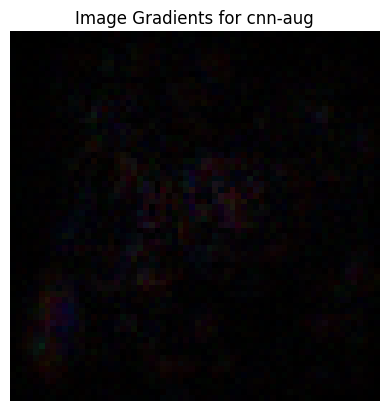

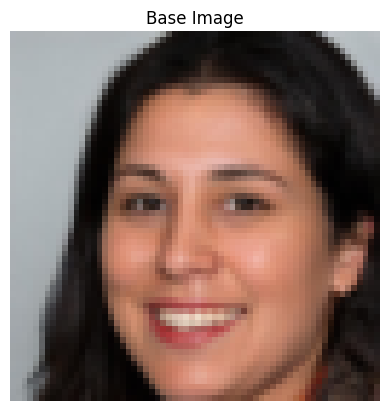

In [29]:
plot_image_gradients()

### using gradcam

In [34]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

def plot_gradcam():
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data = FaceImageDataset('valid', do_fft=False, do_augment=False)

    # pick a real image (label=0)
    base_image, label = None, None
    while label != 0:
        i = np.random.randint(len(data))
        base_image, label = data[i]

    for spec in SPECS:
        model_name, f_model, do_fft, _, _, _ = spec
        if do_fft:
            continue  # skip FFT models

        # prepare image
        image = torch.clone(base_image).unsqueeze(0)  # (1,3,H,W)
        image = image.to(device)

        # load model
        model = f_model()
        # model = nn.DataParallel(model)
        model = model.to(device)



        f_saved_model = os.listdir(f"../deepfakedetection/{SAVED_MODELS_DIR}/{model_name}")[0]

        state_dict = torch.load(f"../deepfakedetection/{SAVED_MODELS_DIR}/{model_name}/{f_saved_model}", map_location=device)

        # create new OrderedDict without "module."
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k.replace("module.", "")  # remove `module.`
            new_state_dict[name] = v

        model.load_state_dict(new_state_dict)

        model.eval()

        # pick the last conv layer for Grad-CAM
        target_layer = model[0]

        activations = {}
        gradients = {}

        def forward_hook(module, inp, out):
            activations["value"] = out.detach()

        def backward_hook(module, grad_in, grad_out):
            gradients["value"] = grad_out[0].detach()

        # register hooks
        h1 = target_layer.register_forward_hook(forward_hook)
        h2 = target_layer.register_backward_hook(backward_hook)

        # forward
        out = model(image)
        class_idx = out.argmax(dim=1).item()  # predicted class
        score = out[0, class_idx]

        # backward
        model.zero_grad()
        score.backward()

        # compute Grad-CAM
        act = activations["value"]        # shape (B,C,H,W)
        grad = gradients["value"]         # shape (B,C,H,W)
        weights = grad.mean(dim=(2, 3), keepdim=True)  # global average pooling
        cam = (weights * act).sum(dim=1, keepdim=True) # linear comb of channels
        cam = torch.relu(cam)             # ReLU
        cam = cam.squeeze().cpu().numpy()

        # normalize
        cam -= cam.min()
        cam /= cam.max()
        cam = cv2.resize(cam, (IMAGE_SIZE, IMAGE_SIZE))

        # overlay on image
        base_np = tensor_to_image(base_image)   # (H,W,3) in [0,1]
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        overlay = np.uint8(0.5 * heatmap + 255 * base_np)

        # save
        # if not os.path.exists('plots/gradcam'):
        #     os.makedirs('plots/gradcam')
        # plt.imsave(f'plots/gradcam/{model_name}_gradcam.png', overlay)

        # display the image 
        plt.imshow(overlay)
        plt.axis('off')
        plt.title(f"Grad-CAM for {model_name}")
        plt.show()


        # remove hooks
        h1.remove()
        h2.remove()

    # also save base image
    # plt.imsave('plots/gradcam/base.png', tensor_to_image(base_image))

    plt.imshow(tensor_to_image(base_image))
    plt.axis('off')
    plt.title("Base Image")
    plt.show()


/home/vishnu/AAT/Self/deepfakedetection/dfvenv/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


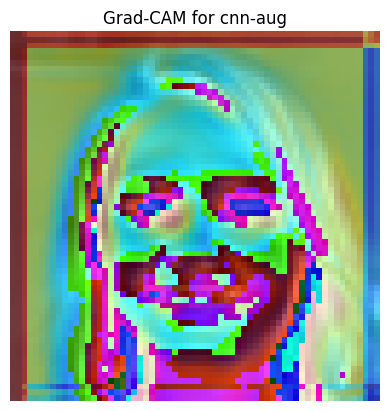

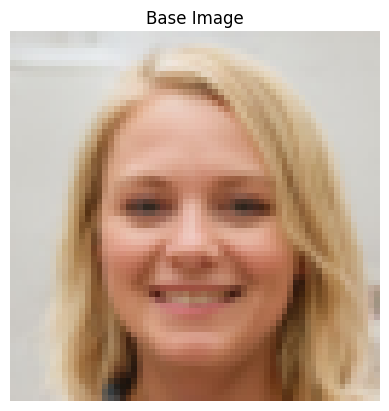

In [66]:
plot_gradcam()